# **Import library and Mount drive**

In [2]:
!apt-get install -y libsndfile1

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1 is already the newest version (1.0.28-7ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.


In [3]:
!pip install pydub
!pip install xgboost
!pip install catboost

In [6]:
import xgboost as xgb
import pandas as pd
import numpy as np
import catboost as cb
import seaborn as sns
import subprocess
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import lightgbm as lgb
import tensorflow as tf
from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

import librosa
import os
from pydub import AudioSegment
import librosa.display

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Turn all Audio file to 3 second long**

In [5]:
main_dir = '/content/drive/MyDrive/Sound_Expression/audio_speech_actors_01-24'

In [ ]:
def cut_audio_to_3s(input_folder):
    for folder_name in os.listdir(main_dir):
        folder_path = os.path.join(main_dir, folder_name)
        # Iterate through each audio file in the subfolder
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.wav') or file_name.endswith('.mp3'):
                # Load the audio file
                input_path = os.path.join(folder_path, file_name)
                try:
                    audio = AudioSegment.from_file(input_path)
                    if len(audio) < 3000:
                        silence_duration = 3000 - len(audio)
                        silence = AudioSegment.silent(duration=silence_duration)
                        three_sec_audio = audio + silence
                    else:
                        # Truncate the audio to 3 seconds
                        three_sec_audio = audio[:3000]

                    # Save the 3-second audio to the output folder
                    three_sec_audio.export(input_path, format="wav")

                except Exception as e:
                    print(f"Error processing file: {input_path}")
                    print(e)
                    # Use ffmpeg to get more detailed information
                    result = subprocess.run(['ffmpeg', '-i', input_path], stderr=subprocess.PIPE)
                    print(result.stderr.decode('utf-8'))  # Print ffmpeg's error output

cut_audio_to_3s(main_dir)

# **Take sound data from folder**

In [6]:
def label_from_folder(file_name):
    string = file_name
    # Split the string by hyphen
    numbers = string.split('-')
    # Access the third number (index 2)
    third_number = numbers[2]

    if '01' in third_number:
        return 'Neutral'
    elif '02' in third_number:
        return 'Calm'
    elif '03' in third_number:
        return 'Happy'
    elif '04' in third_number:
        return 'Sad'
    elif '05' in third_number:
        return 'Angry'
    elif '06' in third_number:
        return 'Fearful'
    elif '07' in third_number:
        return 'Disgust'
    elif '08' in third_number:
        return 'Surprised'
    else:
        return 'Unknown'

# Dictionary to store file paths and their corresponding labels
data = {'file_path': [], 'label': []}

# Iterate through each subfolder
for folder_name in os.listdir(main_dir):
    folder_path = os.path.join(main_dir, folder_name)
    # Iterate through each audio file in the subfolder
    for file_name in os.listdir(folder_path):
      if file_name.endswith('.wav') or file_name.endswith('.mp3'):
        label = label_from_folder(file_name)
        file_path = os.path.join(folder_path, file_name)
        data['file_path'].append(file_path)
        data['label'].append(label)

# Convert to DataFrame
df = pd.DataFrame(data)

In [7]:
df

,file_path,label
0,/content/drive/MyDrive/Sound_Expression/audio_...,Neutral
1,/content/drive/MyDrive/Sound_Expression/audio_...,Calm
2,/content/drive/MyDrive/Sound_Expression/audio_...,Neutral
3,/content/drive/MyDrive/Sound_Expression/audio_...,Calm
4,/content/drive/MyDrive/Sound_Expression/audio_...,Happy
...,...,...
1434,/content/drive/MyDrive/Sound_Expression/audio_...,Surprised
1435,/content/drive/MyDrive/Sound_Expression/audio_...,Surprised
1436,/content/drive/MyDrive/Sound_Expression/audio_...,Surprised
1437,/content/drive/MyDrive/Sound_Expression/audio_...,Surprised


# **Save output CSV to folder And Plot example**

In [ ]:
output_file_path = '/content/drive/MyDrive/Sound_Expression/audio_labels.csv'
df.to_csv(output_file_path, index=False)

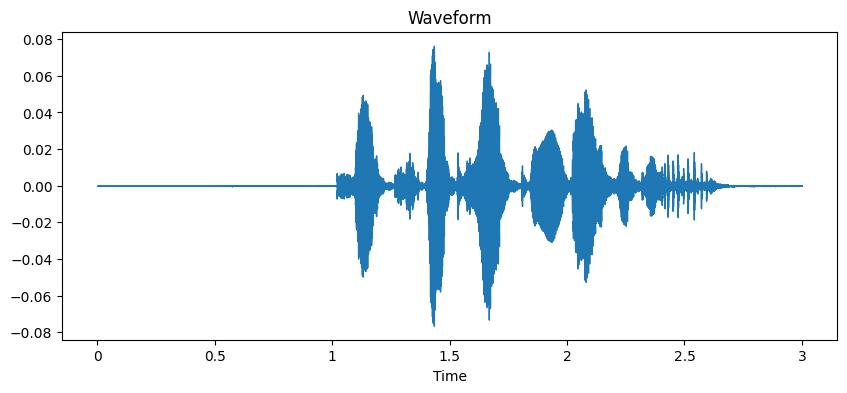

<ipython-input-22-efbc979e0c04>:12: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.

  D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)


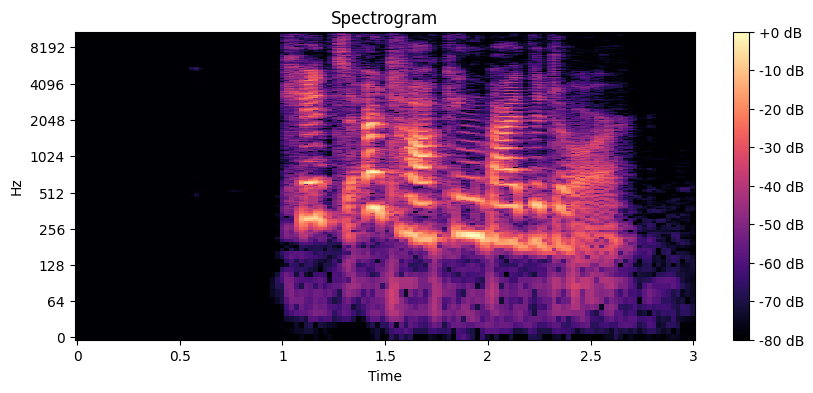

In [ ]:
# Load an example audio file
example_file = os.path.join(main_dir, '/content/drive/MyDrive/Sound_Expression/audio_speech_actors_01-24/Actor_02/03-01-01-01-01-01-02.wav')
y, sr = librosa.load(example_file)

# Display waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.show()

# Display spectrogram
D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

# **Data Extraction**

In [ ]:
def extract_mfcc(file_path, n_mfcc=40):
    frame_size = 400  # 25 ms at 16 kHz
    hop_length = 200  # 12.5 ms at 16 kHz
    X, srr = librosa.load(file_path, sr=None)
    mfccs=np.mean(librosa.feature.mfcc(y=X, sr=srr, n_mfcc=n_mfcc, n_fft=frame_size, hop_length=hop_length).T, axis=0)
    mfcc_delta = librosa.feature.delta(mfccs)
    mfcc_delta2 = librosa.feature.delta(mfccs, order=2)
    return mfccs, mfcc_delta, mfcc_delta2

In [ ]:
sample="/content/drive/MyDrive/Sound_Expression/audio_speech_actors_01-24/Actor_24/03-01-01-01-01-02-24.wav"
mfccs, mfcc_delta, mfcc_delta2 = extract_mfcc(sample, n_mfcc=40)
mfcc_delta2.shape

(40,)

In [ ]:
def flatten_features(mfccs,mfcc_delta,mfcc_delta2):
    mfccs=mfccs.flatten()
    mfcc_delta=mfcc_delta.flatten()
    mfcc_delta2=mfcc_delta2.flatten()
    # Concatenate and flatten the features
    combined_features = np.concatenate((mfccs,mfcc_delta,mfcc_delta2), axis=0)
    return combined_features

In [ ]:
sample="/content/drive/MyDrive/Sound_Expression/audio_speech_actors_01-24/Actor_24/03-01-01-01-01-02-24.wav"
mfccs, mfcc_delta, mfcc_delta2= extract_mfcc(sample, n_mfcc=40)
m=flatten_features(mfccs,mfcc_delta,mfcc_delta2)
print(m.shape)

(120,)


In [ ]:
m

array([-8.7880615e+02,  4.2505436e+01, -2.6118071e+01,  2.3557870e+00,
        4.2406754e+00,  9.6034327e+00, -7.9665041e+00, -2.2624679e+00,
       -1.1070573e+01, -6.4312797e+00,  9.9521285e-01, -1.1634970e+00,
       -4.1464515e+00, -3.5081563e+00,  4.7739869e-01, -2.3875217e+00,
       -2.9893005e+00,  2.5618367e+00, -1.8435050e+00, -2.1322784e+00,
       -1.9781044e+00, -4.5108538e+00, -4.5266266e+00, -5.6378183e+00,
       -3.9493055e+00, -9.3365371e-01, -1.6850389e+00, -6.6577905e-01,
       -3.8034265e+00, -5.2629948e+00, -1.5976372e+00,  9.9219120e-01,
        3.2737162e+00,  2.2692194e+00, -1.0435627e+00, -3.9194314e+00,
       -6.4876208e+00, -4.1558371e+00, -3.8701537e+00, -3.4847658e+00,
        5.6336491e+01,  5.6336491e+01,  5.6336491e+01,  5.6336491e+01,
        5.6336491e+01, -2.8674676e+00,  6.6005892e-01, -9.8311692e-01,
       -8.6824459e-01, -4.4537452e-01,  8.1924284e-01,  5.8080471e-01,
        6.8460125e-01,  4.3657878e-01,  5.4267768e-02,  1.9511667e-01,
      

In [ ]:
output_file_path = '/content/drive/MyDrive/Sound_Expression/features_extraction.csv'
m=np.zeros((1439,120))
df2=pd.DataFrame(m)
df2.to_csv(output_file_path, index=False)

In [ ]:
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def extract_features_to_csv(file_paths, labels, output_csv, n_mfcc=40, max_length=120):
    with open(output_csv, 'w') as f:
        # Write header
        header = ['File'] + [f'Feature_{i}' for i in range(max_length)] + ['Label']
        f.write(','.join(header) + '\n')

        for i, file_path in enumerate(file_paths):
            # Extract features
            mfccs,mfcc_delta,mfcc_delta2= extract_mfcc(file_path, n_mfcc=n_mfcc)
            flattened_features = flatten_features(mfccs,mfcc_delta,mfcc_delta2)
            label = labels[i]

            # Write row
            row = [f'File_{i}'] + flattened_features.tolist() + [label]
            f.write(','.join(map(str, row)) + '\n')

file_paths = df.iloc[:, 0].values
labels = df.iloc[:, -1].values
output_csv = '/content/drive/MyDrive/Sound_Expression/features_extraction.csv'
extract_features_to_csv(file_paths, labels, output_csv, n_mfcc=40, max_length=120)

/usr/local/lib/python3.10/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


In [7]:
df5=pd.read_csv('/kaggle/input/cccccsad/features_extraction.csv')

In [8]:
df5.head()

,File,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,...,Feature_111,Feature_112,Feature_113,Feature_114,Feature_115,Feature_116,Feature_117,Feature_118,Feature_119,Label
0,File_0,-899.346069,32.531887,-33.817184,7.570754,6.082529,10.584245,-11.436819,-0.961268,-10.697849,...,-0.412477,-0.999853,-0.893842,-0.398864,0.369642,0.369642,0.369642,0.369642,0.369642,Neutral
1,File_1,-1000.576111,21.916056,-21.368122,12.250976,3.601930,11.353006,-5.412685,-0.157168,-10.195058,...,-0.345530,-0.754515,-0.649922,-0.291472,0.256190,0.256190,0.256190,0.256190,0.256190,Calm
2,File_2,-903.146240,26.399696,-28.600018,8.960649,3.997856,12.410592,-11.323064,-0.321365,-12.953524,...,-0.449907,-0.949165,-0.743547,-0.275729,0.371048,0.371048,0.371048,0.371048,0.371048,Neutral
3,File_3,-980.440002,20.740654,-25.198479,13.071759,1.060415,14.652720,-8.243542,-0.700215,-11.286477,...,-0.374450,-0.890915,-0.801550,-0.344956,0.303733,0.303733,0.303733,0.303733,0.303733,Calm
4,File_4,-762.365051,37.114128,-30.194338,4.168355,7.450680,7.960943,-10.446024,-1.393561,-8.528953,...,-0.465276,-0.887537,-0.700382,-0.214717,0.332603,0.332603,0.332603,0.332603,0.332603,Happy


In [ ]:
y=df5.iloc[:,-1]

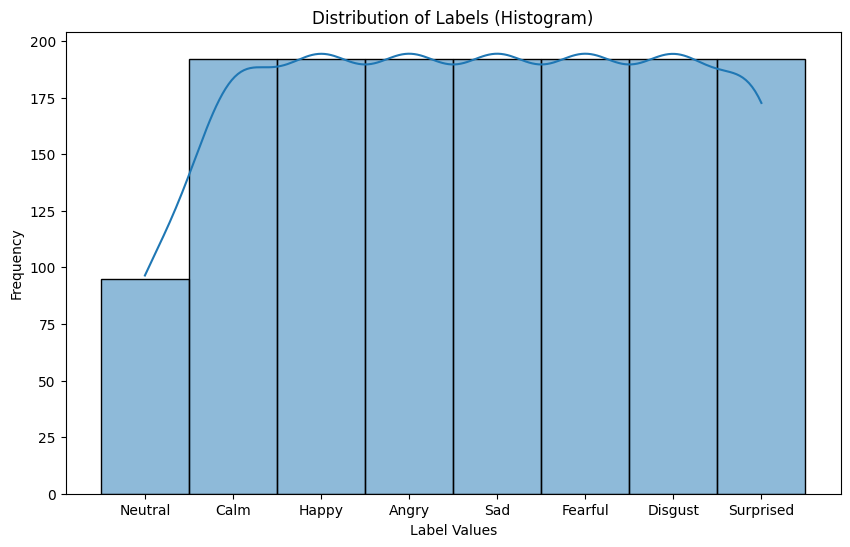

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=30, kde=True)
plt.xlabel('Label Values')
plt.ylabel('Frequency')
plt.title('Distribution of Labels (Histogram)')
plt.show()

# **Others Features we can considered when the model are not satisfy**

# Extract chroma features
chroma = librosa.feature.chroma_stft(y=y, sr=sr)

# Extract spectral contrast
spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

# Extract spectral centroid
spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)

# Extract zero-crossing rate
zero_crossing_rate = librosa.feature.zero_crossing_rate(y)

# Extract root mean square energy
rms = librosa.feature.rms(y=y)

# Extract mel spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)


In [ ]:
# Load audio file
# y, sr = librosa.load('your_audio_file.wav', sr=None)

# Extract MFCCs
# mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Extract delta and delta-delta coefficients
# mfcc_delta = librosa.feature.delta(mfcc)
# mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

# Extract chroma features
# chroma = librosa.feature.chroma_stft(y=y, sr=sr)

# Extract spectral contrast
# spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

# Extract spectral centroid
# spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)

# Extract zero-crossing rate
# zero_crossing_rate = librosa.feature.zero_crossing_rate(y)

# Extract root mean square energy
# rms = librosa.feature.rms(y=y)

# Extract mel spectrogram
# mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

# Combine all features
# features = np.concatenate((mfcc, mfcc_delta, mfcc_delta2, chroma, spectral_contrast,
#                            spectral_centroid, zero_crossing_rate, rms, mel_spectrogram), axis=0)

# Shape of features
# print("Shape of combined features: ", features.shape)

# **Split data frame to smaller data (X,y)**

In [22]:
X=df5.iloc[:,1:-1]
y=df5.iloc[:,-1]

In [23]:
# Encode string class values as integers to avoid errors in newer versions of XGBoost
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
y = label_encoder.transform(y)

In [25]:
X=np.array(X)
y=np.array(y)

In [26]:
# using the train test split function
X_train, X_test, y_train, y_test = train_test_split(X,y ,
                                   random_state=104,
                                   test_size=0.25,
                                   shuffle=True)

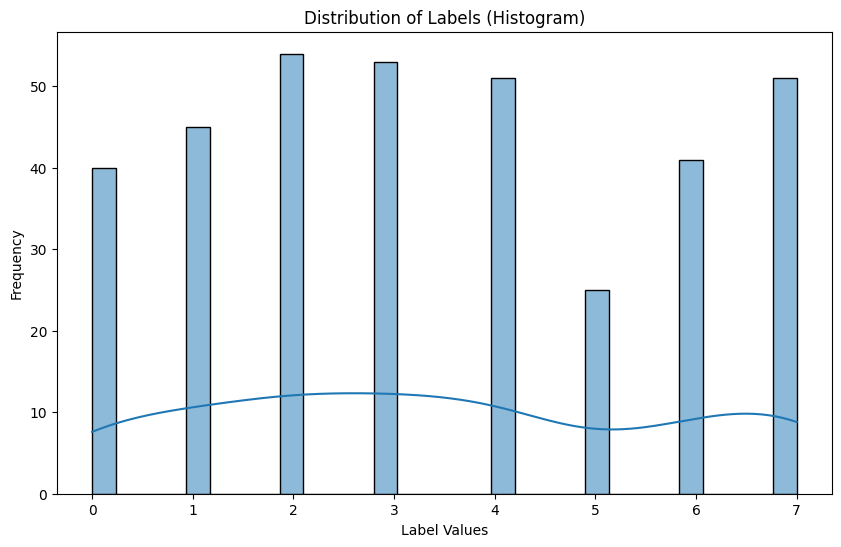

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(y_test, bins=30, kde=True)
plt.xlabel('Label Values')
plt.ylabel('Frequency')
plt.title('Distribution of Labels (Histogram)')
plt.show()

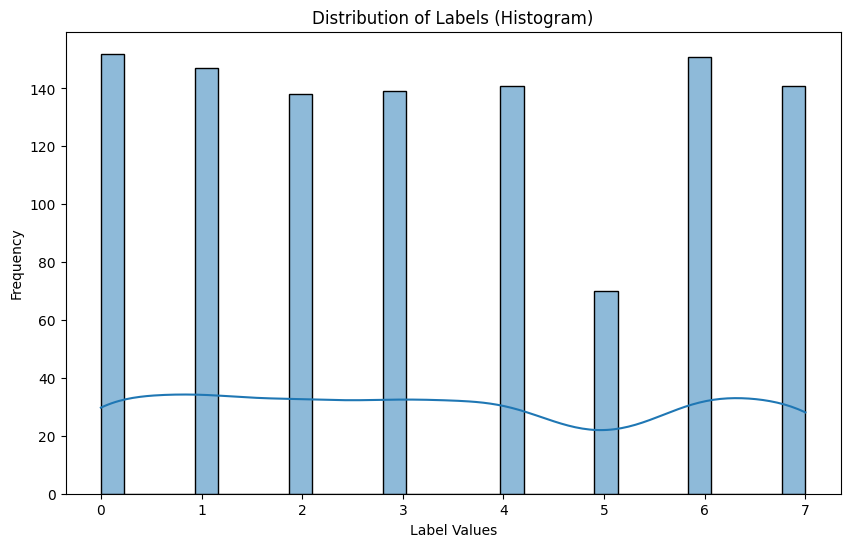

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(y_train, bins=30, kde=True)
plt.xlabel('Label Values')
plt.ylabel('Frequency')
plt.title('Distribution of Labels (Histogram)')
plt.show()

In [ ]:
print(X.shape)
print(y.shape)
print(X[1,-1])

(1439, 40)

(1439,)

2.248993158340454


## **SVM model**

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
kernels = ['linear', 'rbf', 'poly']
C_values = [0.1, 100]

# Loop through each kernel and C value
results = []
for kernel in kernels:
    for C in C_values:
        svm = SVC(kernel=kernel, C=C, random_state=42)
        svm.fit(X_train, y_train)

        # Make predictions
        y_pred = svm.predict(X_test)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)

        # Store the results
        results.append((kernel, C, accuracy))

print("Kernel\t\tC\tAccuracy")
for kernel, C, accuracy in results:
    print(f"{kernel}\t{C}\t{accuracy * 100:.2f}%")

Kernel		C	Accuracy

linear	0.1	50.00%

linear	100	50.00%

rbf	0.1	32.22%

rbf	100	71.11%

poly	0.1	32.50%

poly	100	61.39%


## **Using XGBoost**

In [ ]:
# Create the DMatrix for training and testing
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [ ]:
params = {
    'objective': 'multi:softprob',
    'max_depth': 10,
    'learning_rate': 0.01,
    'eta': 0.3,
    'eval_metric': 'logloss',
    'num_class':8
}

In [ ]:
# Train the model
bst = xgb.train(params, dtrain, num_boost_round=1000, )

In [ ]:
# Make predictions
y_pred_prob = bst.predict(dtest)
y_pred = [int(np.argmax(line)) for line in y_pred_prob]  # Convert probabilities to class predictions

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.62


In [ ]:
# Calculate precision and recall
precision = precision_score(y_test, y_pred, average='macro')  # Use 'micro' or 'weighted' as needed
recall = recall_score(y_test, y_pred, average='macro')

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

Precision: 0.64

Recall: 0.63


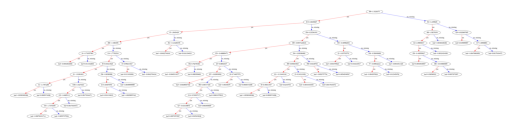

In [ ]:
xgb.plot_tree(bst, num_trees=0)
plt.show()

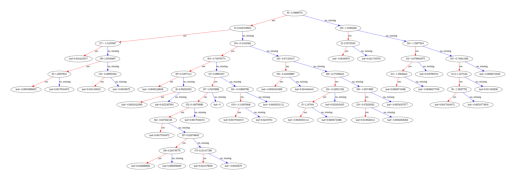

In [ ]:
xgb.plot_tree(bst, num_trees=1)
plt.show()

## **Using LightGBM**

In [ ]:
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb

In [ ]:
# train
gbm = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.01, n_estimators=500)
gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric="l1", callbacks=[lgb.early_stopping(15)])

print("Starting predicting...")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001712 seconds.

You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 30600

[LightGBM] [Info] Number of data points in the train set: 1079, number of used features: 120

[LightGBM] [Info] Start training from score 3.379981

Training until validation scores don't improve for 15 rounds

Did not meet early stopping. Best iteration is:

[500]	valid_0's l1: 1.44015	valid_0's l2: 3.04825

Starting predicting...


In [ ]:
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
# eval
rmse_test = mean_squared_error(y_test, y_pred) ** 0.5
print(f"The RMSE of prediction is: {rmse_test}")

# feature importances
print(f"Feature importances: {list(gbm.feature_importances_)}")

The RMSE of prediction is: 1.7459236614285725

Feature importances: [182, 160, 201, 291, 101, 180, 172, 308, 151, 223, 69, 125, 132, 226, 129, 100, 147, 140, 150, 196, 173, 143, 184, 104, 146, 184, 131, 206, 122, 172, 143, 50, 47, 96, 203, 108, 203, 211, 160, 91, 269, 0, 0, 0, 0, 183, 135, 86, 178, 160, 147, 244, 114, 164, 243, 172, 201, 190, 152, 101, 144, 71, 83, 153, 115, 67, 62, 40, 141, 99, 42, 67, 109, 80, 71, 66, 0, 0, 0, 0, 211, 0, 0, 0, 0, 186, 258, 237, 97, 270, 168, 254, 97, 220, 112, 135, 127, 121, 200, 93, 121, 176, 97, 129, 129, 179, 78, 158, 97, 139, 70, 65, 116, 107, 70, 74, 0, 0, 0, 0]


In [ ]:
def rmsle(y_true, y_pred):
    return "RMSLE", np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))), False


print("Starting training with custom eval function...")
# train
gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric=rmsle, callbacks=[lgb.early_stopping(15)])

Starting training with custom eval function...

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001460 seconds.

You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 30600

[LightGBM] [Info] Number of data points in the train set: 1079, number of used features: 120

[LightGBM] [Info] Start training from score 3.379981

Training until validation scores don't improve for 15 rounds

Did not meet early stopping. Best iteration is:

[500]	valid_0's l2: 3.04825	valid_0's RMSLE: 0.486169


LGBMRegressor(learning_rate=0.01, n_estimators=500)

In [ ]:
# another self-defined eval metric
# f(y_true: array, y_pred: array) -> name: str, eval_result: float, is_higher_better: bool
# Relative Absolute Error (RAE)
def rae(y_true, y_pred):
    return "RAE", np.sum(np.abs(y_pred - y_true)) / np.sum(np.abs(np.mean(y_true) - y_true)), False


print("Starting training with multiple custom eval functions...")
# train
gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric=[rmsle, rae], callbacks=[lgb.early_stopping(5)])

print("Starting predicting...")

Starting training with multiple custom eval functions...

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001473 seconds.

You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 30600

[LightGBM] [Info] Number of data points in the train set: 1079, number of used features: 120

[LightGBM] [Info] Start training from score 3.379981

Training until validation scores don't improve for 5 rounds

Did not meet early stopping. Best iteration is:

[500]	valid_0's l2: 3.04825	valid_0's RMSLE: 0.486169	valid_0's RAE: 0.73756

Starting predicting...


In [ ]:
# predict
y_pred_prob = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
y_pred = [int(np.argmax(line)) for line in y_pred_prob]
# eval
rmsle_test = rmsle(y_test, y_pred)[1]
rae_test = rae(y_test, y_pred)[1]
print(f"The RMSLE of prediction is: {rmsle_test}")
print(f"The RAE of prediction is: {rae_test}")

The RMSLE of prediction is: 1.4689316606027065

The RAE of prediction is: 1.7697268588770863


In [ ]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'multiclass',
    'num_class': 8,
    'metric': 'multi_logloss',
    'num_leaves': 31,
    'learning_rate': 0.01
}

model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=500)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001595 seconds.

You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 30600

[LightGBM] [Info] Number of data points in the train set: 1079, number of used features: 120

[LightGBM] [Info] Start training from score -1.959909

[LightGBM] [Info] Start training from score -1.993357

[LightGBM] [Info] Start training from score -2.056536

[LightGBM] [Info] Start training from score -2.049316

[LightGBM] [Info] Start training from score -2.035030

[LightGBM] [Info] Start training from score -2.735295

[LightGBM] [Info] Start training from score -1.966510

[LightGBM] [Info] Start training from score -2.035030

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits

In [ ]:
# Dự đoán trên tập test
y_pred = model.predict(X_test)
y_pred_max = y_pred.argmax(axis=1)

# Tính độ chính xác
accuracy = accuracy_score(y_test, y_pred_max)
print(f'Accuracy: {accuracy}')


Accuracy: 0.6361111111111111


## **ANN 2 HiddenLayer**

In [ ]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def silu(x):
    return x * sigmoid(x)

def gradient_silu(x):
    sigmoid_x = sigmoid(x)
    return sigmoid_x + x * sigmoid_x * (1 - sigmoid_x)

def relu(x):
    return np.maximum(0, x)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def grad_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

def grad_relu(x):
    return np.where(x > 0, 1, 0)

def one_hot_encode(y, num_classes):
    one_hot = np.zeros((y.size, num_classes))
    one_hot[np.arange(y.size), y] = 1
    return one_hot

class ANN:
    def accuracy(self, X, y):
        predictions = self.predict(X)
        true_labels = y
        accuracy = np.mean(predictions == true_labels)
        return accuracy * 100

    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, learning_rate=0.01):
        self.W1 = np.random.randn(input_size, hidden_size1) * np.sqrt(2. / input_size)
        self.b1 = np.zeros((1, hidden_size1))
        self.W2 = np.random.randn(hidden_size1, hidden_size2) * np.sqrt(2. / hidden_size1)
        self.b2 = np.zeros((1, hidden_size2))
        self.W3 = np.random.randn(hidden_size2, output_size) * np.sqrt(2. / hidden_size2)
        self.b3 = np.zeros((1, output_size))
        self.learning_rate = learning_rate

    def feedforward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = silu(self.z1)

        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = silu(self.z2)

        self.z3 = np.dot(self.a2, self.W3) + self.b3
        self.a3 = softmax(self.z3)

        return self.a3

    def backpropagate(self, X, y):
        m = y.shape[0]

        dz3 = self.a3 - y
        dW3 = np.dot(self.a2.T, dz3) / m
        db3 = np.sum(dz3, axis=0, keepdims=True) / m

        dz2 = np.dot(dz3, self.W3.T) * gradient_silu(self.z2)
        dW2 = np.dot(self.a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m

        dz1 = np.dot(dz2, self.W2.T) * gradient_silu(self.z1)
        dW1 = np.dot(X.T, dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        self.W3 -= self.learning_rate * dW3
        self.b3 -= self.learning_rate * db3
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1

    def train(self, X, y, epochs=1000):
        for epoch in range(epochs):
            self.feedforward(X)
            self.backpropagate(X, y)
            if epoch % 100 == 0:
                loss = self.compute_loss(y)
                print(f'Epoch {epoch}, Loss: {loss:.4f}')

    def compute_loss(self, y):
      m = y.shape[0]
      epsilon = 1e-10  # Small value to avoid log(0)

      # Get the probabilities of the correct classes
      correct_class_probs = self.a3[range(m), np.argmax(y, axis=1)]

      # Add epsilon to avoid log(0)
      logprobs = -np.log(correct_class_probs + epsilon)

      # Compute average loss
      loss = np.sum(logprobs) / m
      return loss

    def predict(self, X):
        a3 = self.feedforward(X)
        return np.argmax(a3, axis=1)

In [ ]:
def one_hot_encode(y, num_classes):
  one_hot = np.zeros((y.size, num_classes))
  one_hot[np.arange(y.size), y] = 1
  return one_hot

In [ ]:
X_train.shape

(1079, 120)

In [ ]:
y_train_one_hot = one_hot_encode(y_train, num_classes=8)
y_test_one_hot = one_hot_encode(y_test, num_classes=8)

ann = ANN(input_size=120, hidden_size1=128, hidden_size2=256, output_size=8)
train_accuracy = ann.train(X_train, y_train_one_hot, epochs=5000)

train_accuracy = ann.accuracy(X_train, y_train)
print(f'Training Accuracy: {train_accuracy:.2f}%')

test_accuracy = ann.accuracy(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}%')

Epoch 0, Loss: 2.5622

Epoch 100, Loss: 1.6620

Epoch 200, Loss: 1.4665

Epoch 300, Loss: 1.3421

Epoch 400, Loss: 1.2463

Epoch 500, Loss: 1.1662

Epoch 600, Loss: 1.0963

Epoch 700, Loss: 1.0336

Epoch 800, Loss: 0.9765

Epoch 900, Loss: 0.9239

Epoch 1000, Loss: 0.8750

Epoch 1100, Loss: 0.8292

Epoch 1200, Loss: 0.7864

Epoch 1300, Loss: 0.7462

Epoch 1400, Loss: 0.7083

Epoch 1500, Loss: 0.6727

Epoch 1600, Loss: 0.6392

Epoch 1700, Loss: 0.6074

Epoch 1800, Loss: 0.5775

Epoch 1900, Loss: 0.5491

Epoch 2000, Loss: 0.5223

Epoch 2100, Loss: 0.4969

Epoch 2200, Loss: 0.4728

Epoch 2300, Loss: 0.4500

Epoch 2400, Loss: 0.4284

Epoch 2500, Loss: 0.4079

Epoch 2600, Loss: 0.3885

Epoch 2700, Loss: 0.3702

Epoch 2800, Loss: 0.3528

Epoch 2900, Loss: 0.3363

Epoch 3000, Loss: 0.3206

Epoch 3100, Loss: 0.3057

Epoch 3200, Loss: 0.2916

Epoch 3300, Loss: 0.2782

Epoch 3400, Loss: 0.2655

Epoch 3500, Loss: 0.2534

Epoch 3600, Loss: 0.2419

Epoch 3700, Loss: 0.2310

Epoch 3800, Loss: 0.2206

## **DNN**

In [ ]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [ ]:
# Tạo TensorDataset cho tập train và test
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Tạo DataLoader cho tập train và test
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
class FiveLayerANN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, hidden_size5,output_size):
        super(FiveLayerANN, self).__init__()

        # Define the layers
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, hidden_size5)
        self.fc6 = nn.Linear(hidden_size5, output_size)

        # Define the activation function
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Forward pass
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.softmax(self.fc6(x))
        return x

In [ ]:
# Define model parameters
input_size = 120
hidden_size1 = 128
hidden_size2 = 256
hidden_size3 = 128
hidden_size4 = 64
hidden_size5 = 32
output_size = 8

# Instantiate the model
model = FiveLayerANN(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, hidden_size5, output_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
train_losses = []
test_losses = []

num_epochs = 1500

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)

    avg_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Tính toán test loss cho epoch này
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():  # Không tính toán gradient
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item() * inputs.size(0)

    avg_test_loss = running_test_loss / len(test_loader.dataset)
    test_losses.append(avg_test_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')


Epoch [1/1500], Train Loss: 2.0740, Test Loss: 2.0819

Epoch [2/1500], Train Loss: 2.0584, Test Loss: 2.0517

Epoch [3/1500], Train Loss: 2.0239, Test Loss: 2.0264

Epoch [4/1500], Train Loss: 2.0142, Test Loss: 2.0311

Epoch [5/1500], Train Loss: 2.0009, Test Loss: 1.9889

Epoch [6/1500], Train Loss: 1.9862, Test Loss: 2.0143

Epoch [7/1500], Train Loss: 1.9852, Test Loss: 1.9739

Epoch [8/1500], Train Loss: 1.9768, Test Loss: 1.9822

Epoch [9/1500], Train Loss: 1.9507, Test Loss: 1.9764

Epoch [10/1500], Train Loss: 1.9551, Test Loss: 1.9572

Epoch [11/1500], Train Loss: 1.9416, Test Loss: 2.0169

Epoch [12/1500], Train Loss: 1.9396, Test Loss: 1.9483

Epoch [13/1500], Train Loss: 1.9283, Test Loss: 1.9702

Epoch [14/1500], Train Loss: 1.9397, Test Loss: 1.9441

Epoch [15/1500], Train Loss: 1.9085, Test Loss: 1.9571

Epoch [16/1500], Train Loss: 1.9281, Test Loss: 1.9530

Epoch [17/1500], Train Loss: 1.9339, Test Loss: 1.9958

Epoch [18/1500], Train Loss: 1.9278, Test Loss: 1.9397

E

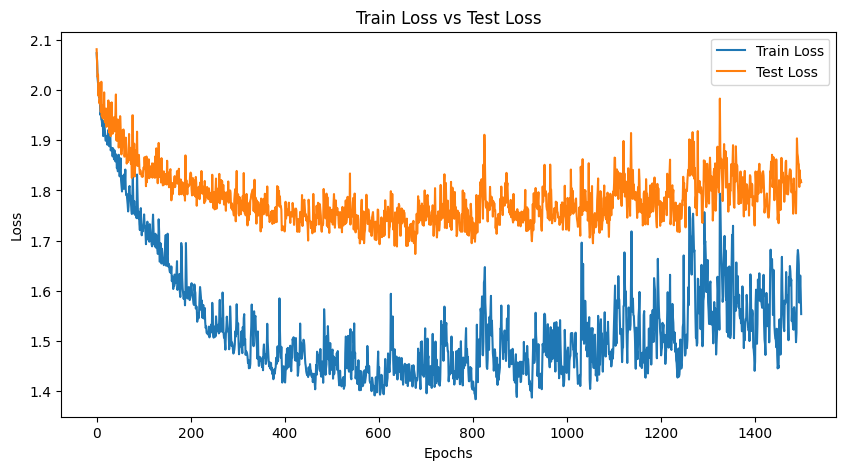

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs Test Loss')
plt.legend()
plt.show()

In [ ]:
def accuracy(model, data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return correct / total

# Calculate accuracy on the training set
train_accuracy = accuracy(model, train_loader)
print(f'Training Accuracy: {train_accuracy:.2%}')

Training Accuracy: 66.73%


## **LSTM Model**

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [26]:
print(X_train.shape)

(1079, 120)


In [14]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [18]:
model = Sequential()

# Adjusted input_shape to match the reshaped input data
model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.5))

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=8, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 120, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 120, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,312 (462.16 KB)

 Trainable params: 118,312 (462.16 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# One-hot encode the target variable
y_train = to_categorical(y_train, num_classes=8)
y_test = to_categorical(y_test, num_classes=8)

# Train the model
history = model.fit(X_train, y_train, epochs=500, batch_size=16, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/500
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.1595 - loss: 2.0776 - val_accuracy: 0.1250 - val_loss: 2.0749
Epoch 2/500
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1194 - loss: 2.0630 - val_accuracy: 0.1574 - val_loss: 2.0700
Epoch 3/500
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1138 - loss: 2.0740 - val_accuracy: 0.1898 - val_loss: 2.0521
Epoch 4/500
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1556 - loss: 2.0289 - val_accuracy: 0.2361 - val_loss: 1.9362
Epoch 5/500
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2208 - loss: 1.9870 - val_accuracy: 0.2407 - val_loss: 1.9206
Epoch 6/500
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2470 - loss: 1.9506 - val_accuracy: 0.2361 - val_loss: 1.9003
Epoch 7/500
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2258 - loss: 1.9250 - val_accuracy: 0.2454 - val_loss: 1.9095
Epoch 8/500
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2206 - loss: 1.8947 - val_accuracy: 0.

## **GRU MODEL**

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

model = Sequential()

model.add(GRU(units=128, input_shape=(120, 1), return_sequences=True))  # 64 units, giữ lại chuỗi đầu ra
model.add(Dropout(0.2))

model.add(GRU(units=64, return_sequences=False))  # 64 units, chỉ giữ lại đầu ra cuối cùng
model.add(Dropout(0.2))

# Lớp Dense để giảm chiều không gian đầu ra
model.add(Dense(units=32, activation='relu'))  # 32 units, hàm kích hoạt relu
model.add(Dropout(0.2))

model.add(Dense(units=8, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 120, 128)       │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 120, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,896 (351.16 KB)

 Trainable params: 89,896 (351.16 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=8)
y_test = to_categorical(y_test, num_classes=8)

history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.2)

# Eval
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Epoch 1/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8860 - loss: 0.3401 - val_accuracy: 0.5000 - val_loss: 2.9422
Epoch 2/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9055 - loss: 0.2529 - val_accuracy: 0.4537 - val_loss: 3.0590
Epoch 3/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9092 - loss: 0.2843 - val_accuracy: 0.4491 - val_loss: 3.4715
Epoch 4/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9012 - loss: 0.2783 - val_accuracy: 0.4537 - val_loss: 3.3412
Epoch 5/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9032 - loss: 0.2663 - val_accuracy: 0.4028 - val_loss: 3.5789
Epoch 6/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9077 - loss: 0.2806 - val_accuracy: 0.4213 - val_loss: 3.0762
Epoch 7/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8718 - loss: 0.3737 - val_accuracy: 0.4213 - val_loss: 3.3346
Epoch 8/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7831 - loss: 0.7188 - val_accuracy: 0.